In [1]:
import cv2
import os
import csv
import time
import math
import torch
import numpy as np
import gala.evaluate as ev
import scipy.sparse as sparse
import matplotlib.pyplot as plt

from PIL import Image
from natsort import ns, natsorted
from skimage import morphology, measure
from skimage.measure import label

from utils.metrics import *
from utils.show_ann import show_anns

from utils.segment_anything_ import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [2]:
"""
    Load model
"""
sam_checkpoint = "../checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"  # use ViT-H pretrained model

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

print("Load model successfully.")

Load model successfully.


In [6]:
"""
    Image path
"""
image_path = "../dataset/test/image/4.png"
label_path = "../dataset/test/label/4.png"

In [7]:
"""
    Load image
"""
image = cv2.imread(image_path)
label_image = cv2.imread(label_path, 0)

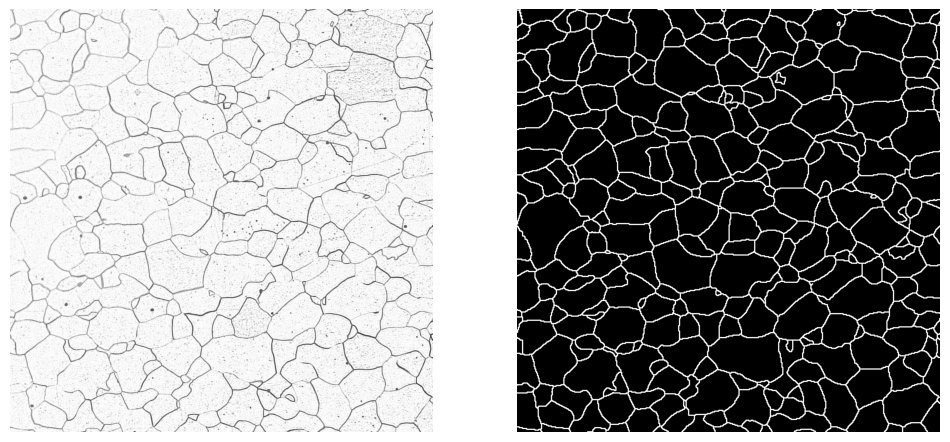

In [8]:
"""
    Origin image and label visualization
"""

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap="gray")
axes[0].axis('off')
axes[1].imshow(label_image, cmap="gray")
axes[1].axis('off')
plt.show()

In [9]:
"""
    Define params
"""
# model iteration layers
layers = 0

# crop points downscale factor
scales = 3

# number of points per side
n_per_side_base = 32

# 1 Canny pre segmentation, 2 OTSU pre segmentation
method_type = 1
# method_type = 2

# predict IoU threshold
pred_iou_thresh = 0.90

# inner boxes filter NMS threshold
box_nms_thresh = 0.80

# all boxes filter NMS threshold
crop_nms_thresh = 0.80

In [11]:
"""
    Load model
"""
from utils.prompt_generator import PromptGenerator

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# generate prompt points
prompter = PromptGenerator(image, layers, scales, n_per_side_base, method_type)
points_layers = prompter.generate_prompt_points()

matsam_mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=None,
    point_grids=points_layers,
    pred_iou_thresh=pred_iou_thresh,
    crop_n_layers=layers,
    crop_n_points_downscale_factor=scales,
    box_nms_thresh=box_nms_thresh,
    crop_nms_thresh=crop_nms_thresh,
    stability_score_thresh=0.92,
    points_per_batch=256,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)


In [12]:
"""
    Run model
"""
masks = matsam_mask_generator.generate(image)

print('Inference successfully, generated {0} masks.'.format(str(len(masks))))

Inference successfully, generated 363 masks.


In [13]:
"""
    Segment result extraction
"""
result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))
tmp_result = np.zeros((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1]))

for i in range(0, len(masks)):
    tmp = np.uint8(masks[i]['segmentation'].astype(int) > 0) * 255
    image_avg_pixel = np.average(image[np.where(tmp > 0)])
    image_sum_area = np.sum(tmp == 255)

    # Set pixel and grayscale threshold based on regional characteristics
    grayscale_threshold = 255
    area_threshold = 25000

    tmp_result += tmp

    if image_sum_area <= area_threshold and image_avg_pixel <= grayscale_threshold:
        """ This step is not required for polyphase structured data """
        tmp = cv2.Laplacian(np.uint8(tmp), cv2.CV_8U)  # Laplace edge segmentation
        tmp = PostPrecess.remove_small_objects(tmp, min_size=50)  # Remove small regions

        result += tmp


/home/hanxu/data/matsam_remote/utils/metrics.py:60: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return morphology.remove_small_objects(label(image), min_size=min_size, connectivity=connectivity)


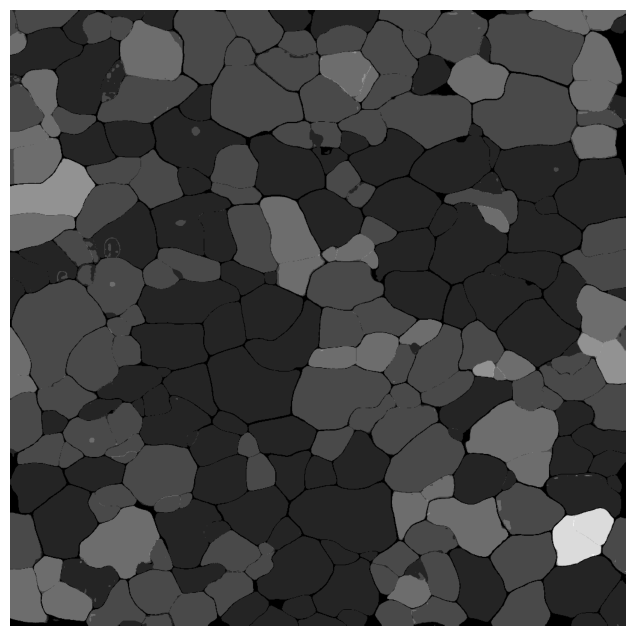

In [14]:
"""
    Temporary image visualization
"""
plt.figure(figsize=(8, 8))
plt.imshow(tmp_result, cmap="gray")
plt.axis('off')  #关闭坐标轴
plt.show()

In [15]:
"""
    *** This step is not required for polyphase structured data. ***
    
    postprocess and extract target area.
    Applicable to data of polycrystalline structure, 
    extract segmentation boundaries from the mask through skeleton, expansion and corrosion operations.
"""
result = np.uint8(result > 0) * 255

result = PostPrecess.skeletonize(np.uint8(result)) * 255  # skeletonization
result = PostPrecess.remove_small_objects(result, min_size=200)  # remove small areas
result = PostPrecess.dilation(np.uint8(result > 0) * 255, square=5)  # dilation
result = PostPrecess.erosion(result, square=3)  # erosion
result = PostPrecess.remove_small_objects(result, min_size=200)  # remove small areas
result = PostPrecess.skeletonize(np.uint8(result)) * 255  # skeletonization
result = PostPrecess.dilation(np.uint8(result > 0) * 255, square=2)  # dilation

result = np.uint8(result > 0) * 255

In [16]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.3)))

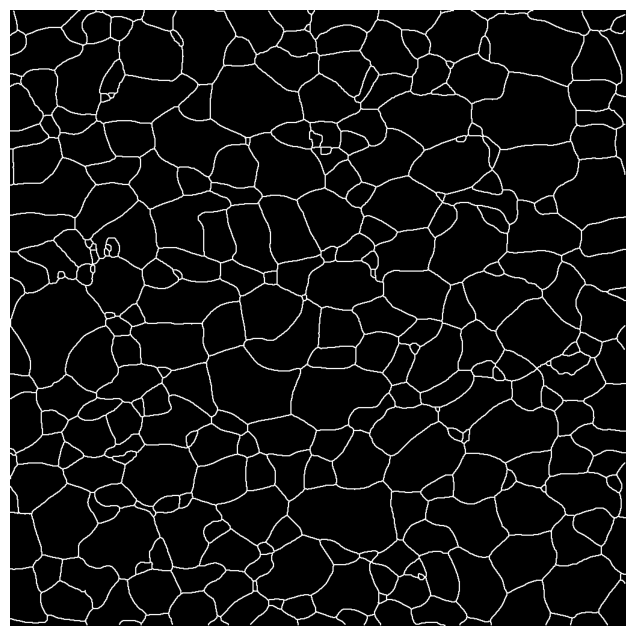

In [17]:
"""
    Result image visualization
"""
plt.figure(figsize=(8, 8))
plt.imshow(result, cmap="gray")
plt.axis('off')  #关闭坐标轴
plt.show()


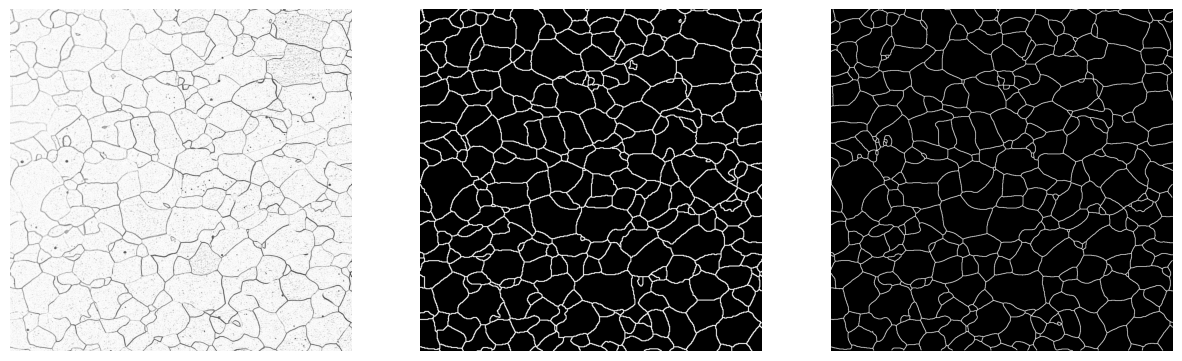

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(image, cmap="gray")
axes[0].axis('off')
axes[1].imshow(label_image, cmap="gray")
axes[1].axis('off')
axes[2].imshow(result, cmap="gray")
axes[2].axis('off')
plt.show()

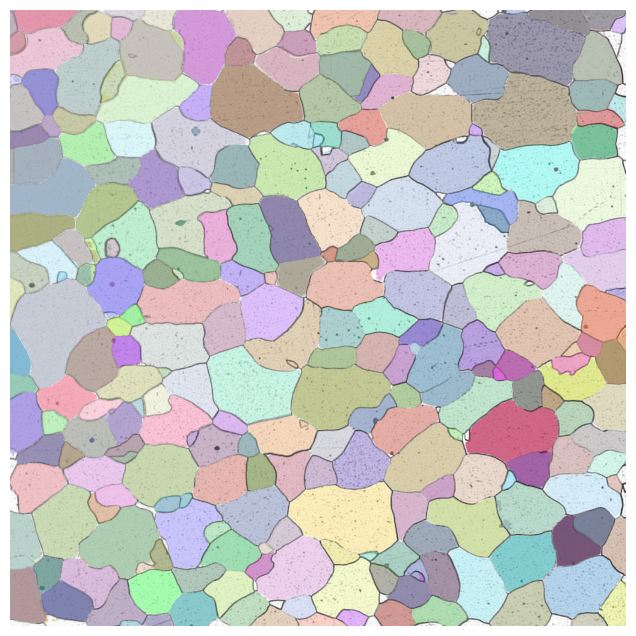

In [22]:
"""
    Colorful result masks visualization
"""
plt.figure(figsize=(8, 8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [22]:
"""
    Calculate evaluation indicators
"""
ari_score = round(Metric.get_ari(result, label_image, 1), 6)
_, _, vi_score = Metric.get_vi(result, label_image, 1)
vi_score = round(vi_score, 6)

# When calculating IoU, pay attention to processing images with 0,1 values.
# Do not enter 0,255 images, as overflow problems will occur.
iou_score = round(Metric.get_iou(np.uint8(result > 0), np.uint8(label_image > 0)), 6)

print('ari:{0}\nvi:{1}\niou:{2}\n'
      .format(str(ari_score), str(vi_score), str(iou_score)))

ari:0.632974
vi:1.083115
iou:0.717306
